Using device: cpu
Training Transformer_10...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10/100 -- Training Loss: 3.0598, Validation Loss: 3.0194, Validation Accuracy: 11.55%
Epoch 20/100 -- Training Loss: 3.0469, Validation Loss: 3.0009, Validation Accuracy: 16.18%
Epoch 30/100 -- Training Loss: 3.0438, Validation Loss: 2.9905, Validation Accuracy: 16.18%
Epoch 40/100 -- Training Loss: 3.0379, Validation Loss: 2.9838, Validation Accuracy: 16.18%
Epoch 50/100 -- Training Loss: 3.0395, Validation Loss: 2.9847, Validation Accuracy: 16.18%
Epoch 60/100 -- Training Loss: 3.0333, Validation Loss: 2.9819, Validation Accuracy: 16.18%
Epoch 70/100 -- Training Loss: 3.0330, Validation Loss: 2.9811, Validation Accuracy: 16.18%
Epoch 80/100 -- Training Loss: 3.0337, Validation Loss: 2.9815, Validation Accuracy: 16.18%
Epoch 90/100 -- Training Loss: 3.0342, Validation Loss: 2.9812, Validation Accuracy: 16.18%
Epoch 100/100 -- Training Loss: 3.0349, Validation Loss: 2.9807, Validation Accuracy: 16.18%
Execution Time: 839.3133234977722 seconds
Model size: 1790380 parameters
Traini

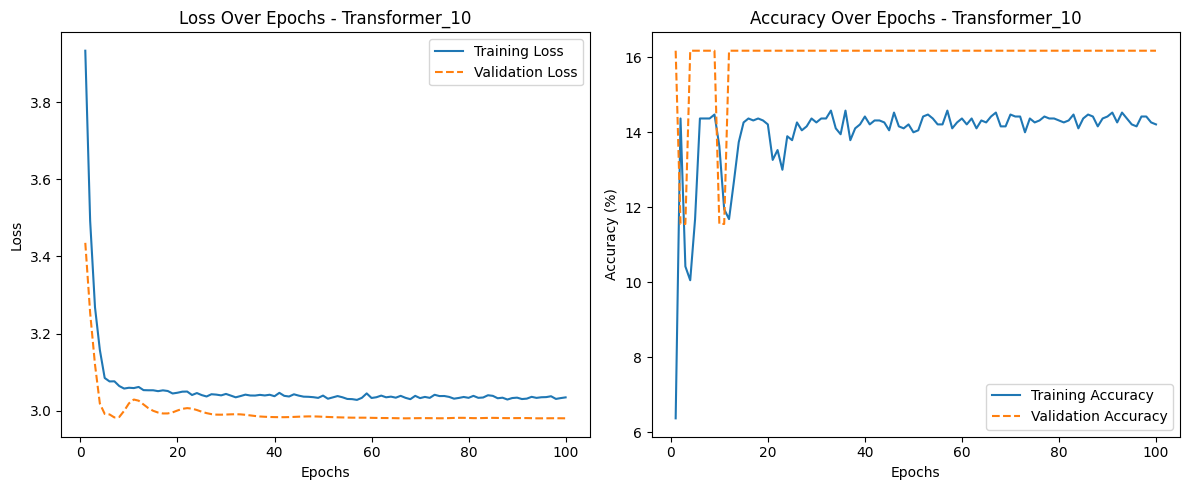

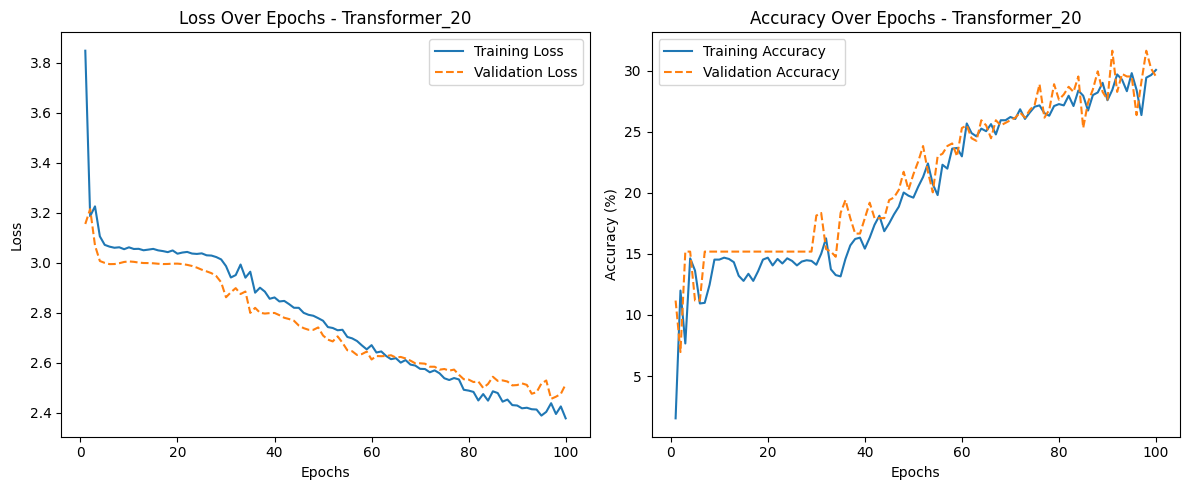

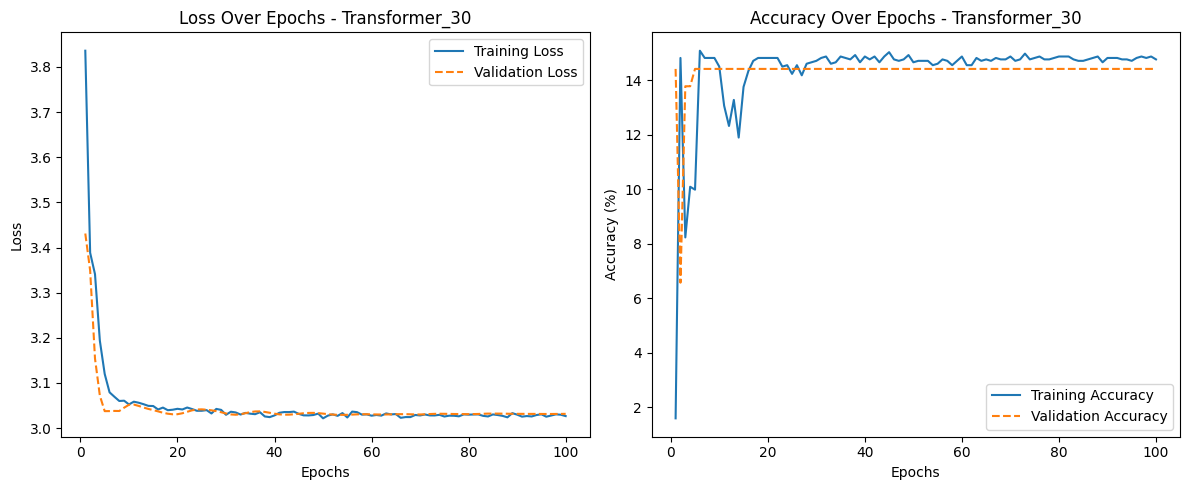

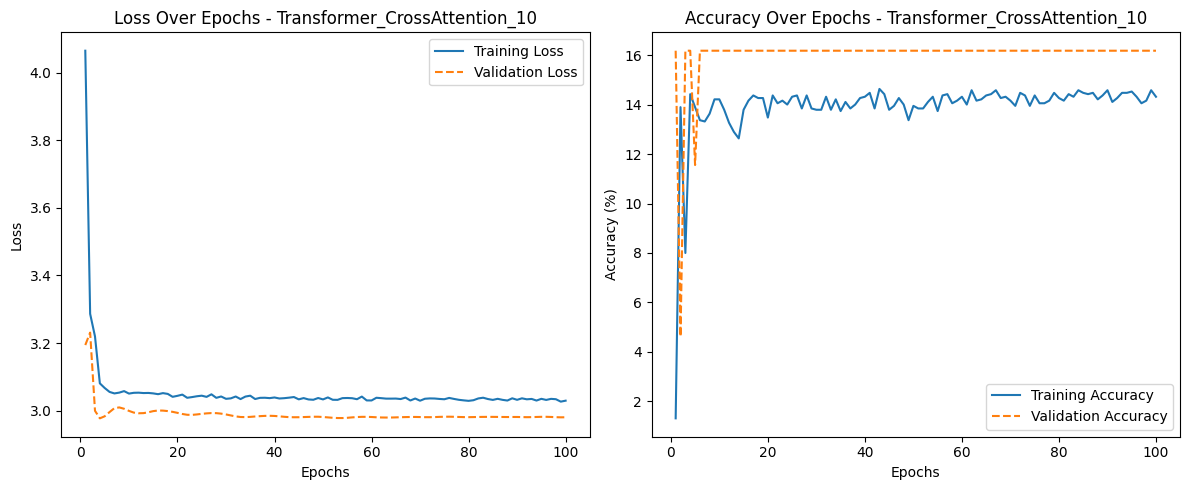

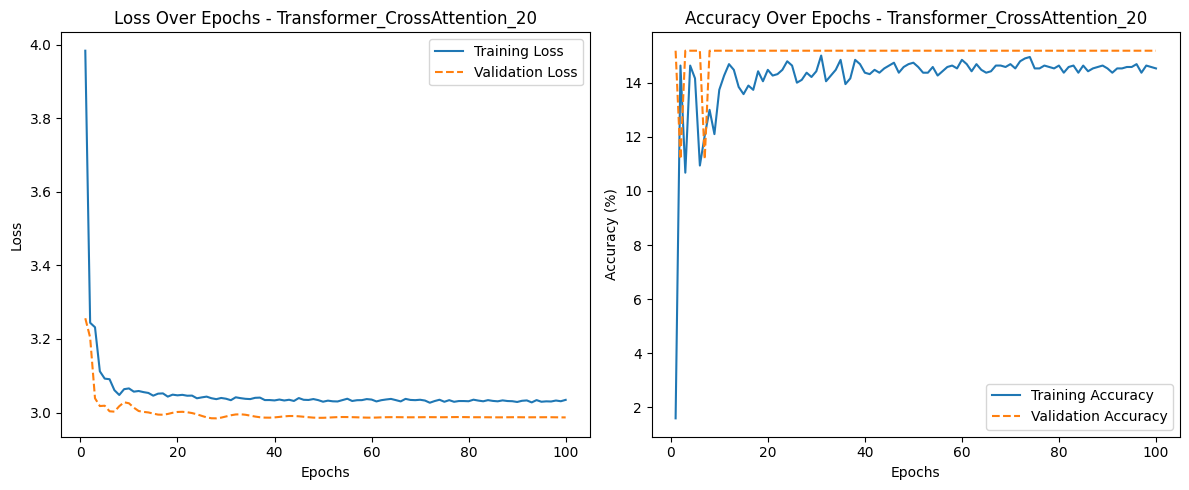

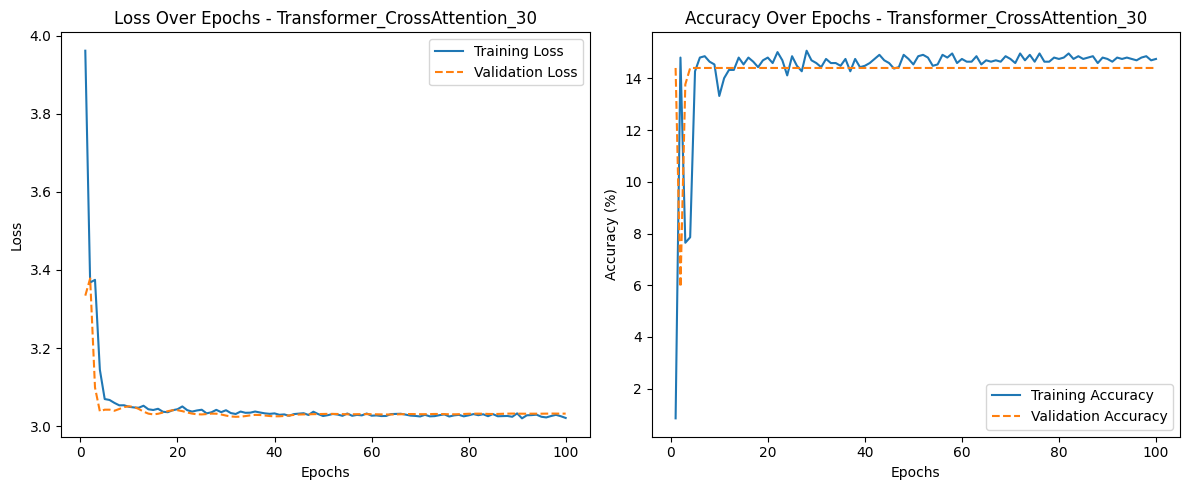

In [3]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import io
import contextlib
from sklearn.model_selection import train_test_split
import numpy as np
import json
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

#Sequence text
text = "Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology."

def text_preparation(text, max_length):
    #set(text): Creates a set of unique characters found in the text. The set function removes any duplicate characters.
    #list(set(text)): Converts the set back into a list so that it can be sorted.
    # sorted(list(set(text))): Sorts the list of unique characters.
    chars = sorted(list(set(text)))
    #This line creates a dictionary that maps each character to a unique index (integer)."
    ix_to_char = {i: ch for i, ch in enumerate(chars)}
    #Similar to the previous line, but in reverse. This line creates a dictionary that maps each unique index (integer) back to its corresponding character.
    char_to_ix = {ch: i for i, ch in enumerate(chars)}

    # Preparing the dataset
    X = []
    y = []
    for i in range(len(text) - max_length):
        sequence = text[i:i + max_length]
        label = text[i + max_length]
        X.append([char_to_ix[char] for char in sequence])
        y.append(char_to_ix[label])

    X = np.array(X)
    y = np.array(y)

    # Splitting the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Converting data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.long).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val = torch.tensor(X_val, dtype=torch.long).to(device)
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

    return X_train, X_val, y_train, y_val, chars

# Defining the RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output[:, -1, :])
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# Positional Encoding for transformer models
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Transformer model without cross-attention (encoder-only)
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead, dropout=0.1):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)  # shape: (batch_size, seq_len, hidden_size)
        x = x.transpose(0, 1)  # shape: (seq_len, batch_size, hidden_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)  # shape remains (seq_len, batch_size, hidden_size)
        # Use the output of the last time step for prediction
        x = self.fc(x[-1, :, :])  # shape: (batch_size, output_size)
        return x, None

    def init_hidden(self, batch_size):
        # Transformer does not use a hidden state; return None for compatibility
        return None

# Transformer model with cross-attention (encoder-decoder)
class CharTransformerWithCrossAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead, dropout=0.1):
        super(CharTransformerWithCrossAttention, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        self.transformer = nn.Transformer(d_model=hidden_size, nhead=nhead,
                                          num_encoder_layers=num_layers, num_decoder_layers=num_layers,
                                          dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

    def forward(self, src, hidden=None):
        # src shape: (batch_size, seq_len)
        # For compatibility, we ignore 'hidden' and generate a dummy target token for the decoder.
        src = self.embedding(src).transpose(0, 1)  # (seq_len, batch_size, hidden_size)
        src = self.pos_encoder(src)
        # Create dummy target: use a tensor filled with zeros of shape (batch_size, 1)
        batch_size = src.shape[1]
        tgt = torch.zeros(batch_size, 1, dtype=torch.long, device=src.device)
        tgt = self.embedding(tgt).transpose(0, 1)  # (1, batch_size, hidden_size)
        tgt = self.pos_encoder(tgt)
        output = self.transformer(src, tgt)
        # Use the output of the decoder (only one token) for prediction
        output = self.fc(output[0])
        return output, None

    def init_hidden(self, batch_size):
        return None


# Function to store results in a JSON file
def store_results(results, filename="results.json"):
    """ Stores the training results into a JSON file for future comparison. """

    for model_name, data in results.items():
        data['true_labels'] = data['true_labels'].tolist()  # Convert to list
        data['predicted_labels'] = data['predicted_labels'].tolist()  # Convert to list

    with open(filename, "w") as f:
        json.dump(results, f, indent=4)
    print(f"Results successfully stored in {filename}")

# Function to visualize training and validation loss & accuracy
def plot_results(filename="results.json"):
    """ Reads results and generates training vs validation plots. """
    if not os.path.exists(filename):
        print(f"No results file found: {filename}")
        return

    with open(filename, "r") as f:
        results = json.load(f)

    for model_name, data in results.items():
        epochs = list(range(1, len(data["training_losses"]) + 1))

        plt.figure(figsize=(12, 5))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, data["training_losses"], label="Training Loss")
        plt.plot(epochs, data["validation_losses"], label="Validation Loss", linestyle="dashed")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Loss Over Epochs - {model_name}")
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, data["training_accuracies"], label="Training Accuracy")
        plt.plot(epochs, data["validation_accuracies"], label="Validation Accuracy", linestyle="dashed")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.title(f"Accuracy Over Epochs - {model_name}")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Function to compare results across models
def compare_results(filename="results.json"):
    """ Loads and compares model performance across different architectures and sequence lengths. """
    if not os.path.exists(filename):
        print(f"No results file found: {filename}")
        return

    with open(filename, "r") as f:
        results = json.load(f)

    print("\nModel Performance Comparison:\n")
    print("{:<20} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
        "Model", "Max Length", "Train Loss", "Val Accuracy", "Exec Time", "Model Size"
    ))

    for model_name, data in results.items():
        train_loss = np.mean(data["training_losses"])
        val_accuracy = np.max(data["validation_accuracies"])  # Best validation accuracy
        exec_time = data["execution_time"]
        model_size = data["model_size"]

        max_length = model_name.split("_")[-1]  # Extract max length from model name
        print("{:<20} {:<15} {:<15.4f} {:<15.2f} {:<15.2f} {:<15}".format(
            model_name, max_length, train_loss, val_accuracy, exec_time, model_size
        ))

# Function to calculate model size (number of parameters)
def calculate_model_size(model):
    """ Computes the total number of trainable parameters in a model. """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_text_network(net, X_train, y_train, X_val, y_val, criterion, optimizer, epochs):
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        optimizer.zero_grad()

        hidden = net.init_hidden(X_train.size(0))
        if hidden is not None:
          if isinstance(hidden, tuple):
            hidden = tuple(h.to(device) for h in hidden)
          else:
            hidden = hidden.to(device)

        output, hidden = net(X_train, hidden)

        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        # Compute training accuracy
        _, predicted = torch.max(output, 1)
        train_accuracy = (predicted == y_train).float().mean().item() * 100
        training_accuracies.append(train_accuracy)

        # Validation
        net.eval()
        with torch.no_grad():
            hidden_val = net.init_hidden(X_val.size(0))
            if hidden_val is not None:
              if isinstance(hidden_val, tuple):
                hidden_val = tuple(h.to(device) for h in hidden_val)
              else:
                hidden_val = hidden_val.to(device)

            val_output, _ = net(X_val, hidden_val)
            val_loss = criterion(val_output, y_val)
            validation_losses.append(val_loss.item())

            _, val_predicted = torch.max(val_output, 1)
            val_accuracy = (val_predicted == y_val).float().mean().item() * 100
            validation_accuracies.append(val_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs} -- '
                  f'Training Loss: {loss.item():.4f}, '
                  f'Validation Loss: {val_loss.item():.4f}, '
                  f'Validation Accuracy: {val_accuracy:.2f}%')

    execution_time = time.time() - start_time
    print(f"Execution Time: {execution_time} seconds")

    model_size = calculate_model_size(net)
    print(f"Model size: {model_size} parameters")

    # Store results
    results = {
        'training_losses': training_losses,
        'training_accuracies': training_accuracies,
        'validation_losses': validation_losses,
        'validation_accuracies': validation_accuracies,
        'true_labels': y_val.cpu().numpy(),
        'predicted_labels': val_predicted.cpu().numpy(),
        'execution_time': execution_time,
        'model_size': model_size
    }

    return results

def compare_models(models):

  results_dict = {}

  for model_name, model_params in models.items():
    print(f"Training {model_params['name']}...")
    X_train, X_val, y_train, y_val, chars = text_preparation(text, model_params["max_length"])

    # Hyperparameters
    input_size = len(chars)
    hidden_size = model_params["hidden_size"]
    output_size = len(chars)

    #Model Class
    model_class = model_params['model_class']
    if model_class in [CharTransformer, CharTransformerWithCrossAttention]:  # Check if it's a Transformer model
        model = model_class(input_size, hidden_size, output_size,
                        num_layers=model_params.get('num_layers', 3),
                        nhead=model_params.get('nhead', 2),
                        dropout=model_params.get('dropout', 0.1)).to(device)
    else: #RNN model
        model = model_class(input_size, hidden_size, output_size).to(device)

    criterion = model_params['criterion']()
    optimizer = model_params['optimizer'](model.parameters(), lr=model_params['learning_rate'])

    results = train_text_network(model, X_train, y_train, X_val, y_val, criterion, optimizer, model_params['epochs'])

    results_dict[model_params['name']] = results

  store_results(results_dict)
  return results_dict

def main():
  models = {}
  # for model_class, model_name in [(CharRNN, "RNN")]:
  #       for length in [10, 20, 30]:
  #           models[f"{model_name}_{length}"] = {
  #               "name": f"{model_name}_{length}",
  #               "model_class": model_class,
  #               "max_length": length,
  #               "hidden_size": 128,
  #               "criterion": nn.CrossEntropyLoss,
  #               "optimizer": optim.Adam,
  #               "learning_rate": 0.005,
  #               "epochs": 100,
  #               "num_layers": 3,     # CHANGED: Standard number of layers for consistency
  #               "nhead": 2           # CHANGED: Not used for RNNs but kept for uniformity in model creation
  #           }
  # New Transformer-based models (encoder-only and with cross-attention)
  for transformer_class, transformer_name in [(CharTransformer, "Transformer"),
                                                (CharTransformerWithCrossAttention, "Transformer_CrossAttention")]:
      for length in [10, 20, 30]:
          models[f"{transformer_name}_{length}"] = {
              "name": f"{transformer_name}_{length}",
              "model_class": transformer_class,
              "max_length": length,
              "hidden_size": 128,
              "criterion": nn.CrossEntropyLoss,
              "optimizer": optim.Adam,
              "learning_rate": 0.005,
              "epochs": 100,
              "num_layers": 3,   # CHANGED: Matching number of layers with RNN models
              "nhead": 2,        # CHANGED: Number of attention heads for the transformer
              "dropout": 0.1
          }

  results = compare_models(models)
  compare_results("results.json")
  plot_results("results.json")

if __name__ == '__main__':
    main()